In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 xformers -U
! pip install accelerate datasets transformers
! pip install bitsandbytes
! pip install peft safetensors wandb

INFO: pip is looking at multiple versions of xformers to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 83.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.2 MB/s eta 0:00:00:00:0100:01


# Required Imports 

In [3]:
from pathlib import Path 
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler,DDIMScheduler,StableDiffusionPipeline,DiffusionPipeline
from transformers import CLIPTextModel,CLIPTokenizer
from huggingface_hub import notebook_login
from peft import LoraConfig
import torch 
from torch.utils.data import DataLoader,Dataset
from torch.nn import functional as F
import math 
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt 
from peft.utils import get_peft_model_state_dict 
from diffusers.utils import convert_state_dict_to_diffusers 
from datasets import load_dataset
from functools import partial 
from kaggle_secrets import UserSecretsClient 
from pydantic import BaseModel 
from diffusers.training_utils import compute_snr 
from PIL import Image
from accelerate import Accelerator

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
notebook_login()

In [5]:
model_name = 'CompVis/stable-diffusion-v1-4'

In [6]:
def get_models(model_name, dtype=torch.float16):
    tokenizer = CLIPTokenizer.from_pretrained(model_name,subfolder='tokenizer')  

    text_encoder = CLIPTextModel.from_pretrained(model_name,subfolder='text_encoder').to(dtype=dtype)  # Removed `from_tf=True`
    vae = AutoencoderKL.from_pretrained(model_name,subfolder='vae').to(dtype=dtype)  
    scheduler = DDIMScheduler(beta_start=0.0001,beta_end=0.02,
                             beta_schedule='scaled_linear',clip_sample=True,
                             set_alpha_to_one=False)
    unet = UNet2DConditionModel.from_pretrained(model_name,subfolder='unet').to(dtype=dtype)

    return tokenizer, text_encoder, vae, scheduler, unet


In [7]:
from torchvision import transforms

class MidjourneyDataset(Dataset):
    def __init__(self,data_dir,tokenizer):
        self.data_dir = Path(data_dir)
        self.df = pd.read_csv(self.data_dir/'index.csv')
        self.tokenizer = tokenizer 

        self.train_transforms = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        image_path = self.data_dir / 'images' / self.df.iloc[idx]['image']
        image = Image.open(image_path).convert('RGB')
        image = self.train_transforms(image)
        input_ids = self.tokenizer(self.df.iloc[idx]['short_prompt'],
                                  max_length=self.tokenizer.model_max_length,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')['input_ids'][0]
        
        return {'pixel_values':image,'input_ids':input_ids}

In [8]:
data_dir = '/kaggle/input/midjourney-v0/midjourney-512px-v0'
model_name = 'CompVis/stable-diffusion-v1-4'
tokenizer,text_encoder,vae,scheduler,unet = get_models(model_name)
dataset = MidjourneyDataset(data_dir,tokenizer)

dataset

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

#  Viewing an instance 

dict_keys(['pixel_values', 'input_ids'])


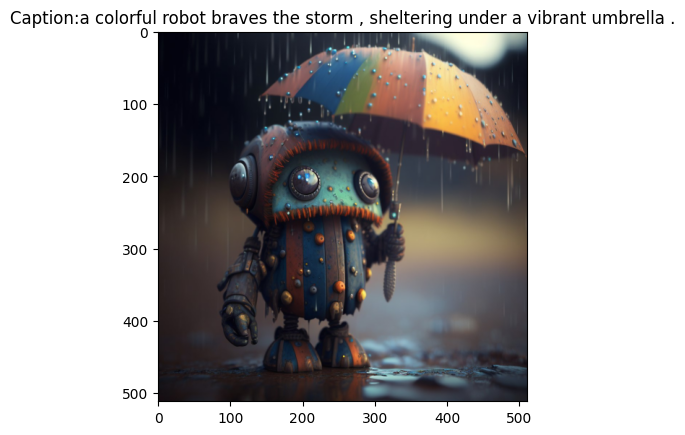

In [9]:
sample = dataset[0]
print(sample.keys())
image = np.array(sample['pixel_values'].permute(1,2,0))
image = (image + 1) / 2
caption = tokenizer.decode(sample['input_ids'].tolist(), skip_special_tokens=True)
plt.imshow(image)
plt.title(f'Caption:{caption}')
plt.show()


In [10]:
def setup_models_for_training(model_name, rank=128):
    tokenizer, text_encoder, vae, scheduler, unet = get_models(model_name)

    for m in (unet, text_encoder, vae):
        for p in m.parameters():
            p.requires_grad = False 

    unet_lora_config = LoraConfig(
        r=rank, lora_alpha=rank,
        init_lora_weights='gaussian',
        target_modules=['to_k', 'to_q', 'to_v', 'to_out.0']
    )
    unet.add_adapter(unet_lora_config)

    for p in unet.parameters():
        if p.requires_grad:
            p.data = p.to(dtype=torch.float32)

    # **Enable Gradient Checkpointing**
    unet.enable_gradient_checkpointing()  

    return tokenizer, text_encoder, vae, scheduler, unet


def get_lora_params(unet):
    return [p for p in filter(lambda p : p.requires_grad, [p for p in unet.parameters()])]
    

In [11]:
tokenizer,text_encoder,vae,scheduler,unet = setup_models_for_training(model_name)
# print(get_lora_params(unet))

In [12]:
class TrainingConfig(BaseModel):
    train_steps:int = 100
    lr:float = 5e-5
    batch_size:int = 1
    gradient_accumulation_steps:int = 2
    rank:int = 128
    max_grad_norm:float = 1.0
    pretrained_name:str = model_name 
    data_dir:str = data_dir
    snr_gamma:float = -1 
    seed:int = -1 

config = TrainingConfig()
print(config)

train_steps=100 lr=5e-05 batch_size=1 gradient_accumulation_steps=2 rank=128 max_grad_norm=1.0 pretrained_name='CompVis/stable-diffusion-v1-4' data_dir='/kaggle/input/midjourney-v0/midjourney-512px-v0' snr_gamma=-1 seed=-1


In [13]:
import os
import torch
import math
import json
from pathlib import Path
from tqdm.auto import tqdm
from accelerate import Accelerator
import torch.nn.functional as F

def train(
    tokenizer, 
    text_encoder, 
    vae, 
    scheduler, 
    unet,
    config,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    # ✅ Move non-trainable models to CPU to free GPU memory
    text_encoder.to("cpu").eval()
    vae.to("cpu").eval()
    unet.to(device).train()

    # ✅ Enable memory-efficient features
    unet.enable_xformers_memory_efficient_attention()
    unet.enable_gradient_checkpointing()

    # ✅ Dataset & DataLoader
    train_dataset = MidjourneyDataset(Path(config.data_dir), tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    optimizer = torch.optim.AdamW(get_lora_params(unet), lr=config.lr)

    # ✅ Checkpoints Directory
    os.makedirs("checkpoints", exist_ok=True)
    checkpoint_path = "checkpoints/latest_checkpoint.pt"

    # ✅ Auto-resume: Load latest checkpoint if available
    start_epoch = 0
    loss_log = []
    if os.path.exists(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=True)
        unet.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        loss_log = checkpoint["loss_log"]

    # ✅ Prepare model for accelerator
    unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)

    steps_per_epoch = math.ceil(len(train_dataloader) / config.gradient_accumulation_steps)
    total_epochs = math.ceil(config.train_steps / steps_per_epoch)
    print(f"Steps per epoch:{steps_per_epoch}\nTotal epochs:{total_epochs}")
    global_step = 0
    progress_bar = tqdm(range(config.train_steps), desc="Training Steps")
    avg_epoch_losses = []
    for epoch in range(start_epoch, total_epochs):
        epoch_losses = []

        for step, batch in enumerate(train_dataloader):
            bs = batch["input_ids"].shape[0]

            with accelerator.autocast():
                with torch.no_grad():
                    text_encoder.to(device)
                    encoder_hidden_states = text_encoder(batch["input_ids"].to(device)).last_hidden_state
                    text_encoder.to("cpu")

                    vae.to(device)
                    latents = vae.encode(batch["pixel_values"].to(device)).latent_dist.sample() * vae.config.scaling_factor
                    vae.to("cpu")

                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bs,), device=device).long()
                noise = torch.randn_like(latents)
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)

                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                loss = F.mse_loss(noise_pred, noise, reduction="mean")

            accelerator.backward(loss)
            epoch_losses.append(loss.item())
            global_step += 1

            if global_step % config.gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                torch.cuda.empty_cache()

            progress_bar.set_postfix({"loss": loss.item()})

        # ✅ Compute and log average epoch loss
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        print(f"Epoch {epoch + 1}/{total_epochs} | Avg Loss: {avg_epoch_loss:.6f}")
        
        avg_epoch_losses.append(avg_epoch_loss)

        # ✅ Save Checkpoint
        checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": unet.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss_log": loss_log + [{"epoch": epoch + 1, "avg_loss": avg_epoch_loss}]
        }
        torch.save(checkpoint_data, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

    return {"losses": loss_log,'avg_epoch_losses':avg_epoch_losses}

In [14]:
try:
    # in case of rerun, to make sure we free up GPU before calling train
    del models, pipe
    import gc; gc.collect()
    torch.cuda.empty_cache()
except:
    pass
    
config = TrainingConfig()
config.lr = 1e-5
config.rank = 62
config.train_steps = 1000
config.snr_gamma = 5.0
config.seed = 42

torch.manual_seed(config.seed)

models = setup_models_for_training(config.pretrained_name, rank=config.rank)

outputs = train(
    *models,
    config,
)


Steps per epoch:376
Total epochs:3


Training Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/3 | Avg Loss: 0.208041
Checkpoint saved: checkpoints/latest_checkpoint.pt
Epoch 2/3 | Avg Loss: 0.204319
Checkpoint saved: checkpoints/latest_checkpoint.pt
Epoch 3/3 | Avg Loss: 0.196442
Checkpoint saved: checkpoints/latest_checkpoint.pt


[0.208040573088046, 0.20431937701273165, 0.19644243437707043]


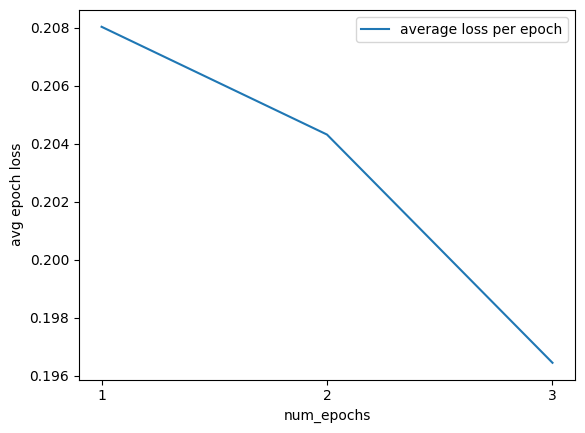

In [19]:
print(outputs['avg_epoch_losses'])
num_epochs = len((outputs['avg_epoch_losses']))
epochs = list(range(1,num_epochs + 1))
plt.plot(epochs,outputs['avg_epoch_losses'],label='average loss per epoch')
plt.xticks(epochs)
plt.xlabel('num_epochs')
plt.ylabel('avg epoch loss')
plt.legend()
plt.show()

In [21]:
unet = models[-1]
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))


In [22]:
StableDiffusionPipeline.save_lora_weights(save_directory="./out",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True)

In [23]:
!ls -l -h ./out/pytorch_lora_weights.safetensors


-rw-r--r-- 1 root root 48M Mar 10 09:44 ./out/pytorch_lora_weights.safetensors


In [24]:
df = pd.read_csv(Path(config.data_dir) / "index.csv")


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

prompt_training = [df.iloc[0]['short_prompt']]
prompt_new = 'a dark forest, detailed, 8k'
num_inference_steps = 35
seed = 3 

In [26]:
def generate(pipeline, prompt, seed):
    generator = torch.Generator(device=device).manual_seed(seed)
    return pipeline(prompt, num_inference_steps=num_inference_steps, generator=generator).images[0]

In [33]:
pipe = StableDiffusionPipeline.from_pretrained(
    config.pretrained_name,
    torch_dtype=torch.float16
).to(device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

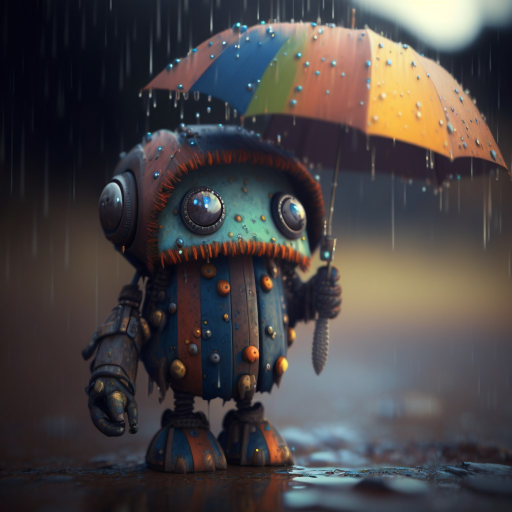

In [28]:
Image.open(Path(config.data_dir) / "images" / df.iloc[0]["image"])


  0%|          | 0/35 [00:00<?, ?it/s]

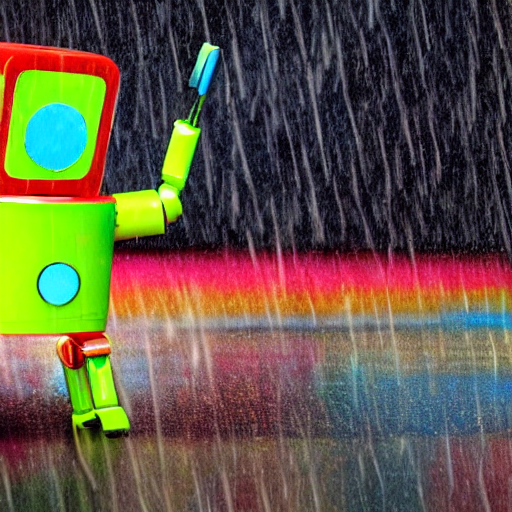

In [34]:
generate(pipe, prompt_training, seed)


  0%|          | 0/35 [00:00<?, ?it/s]

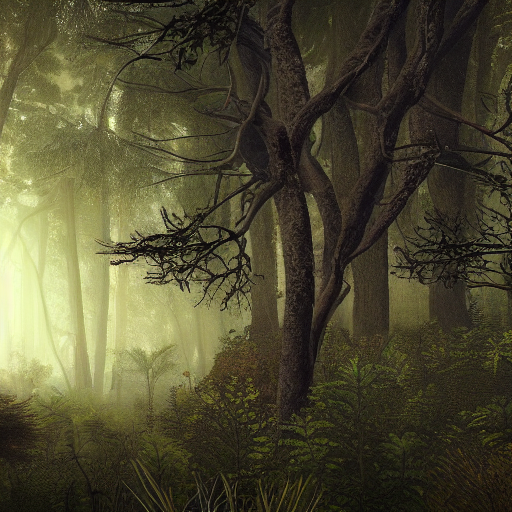

In [35]:
generate(pipe, prompt_new, seed)

# Using LoRA weights

  0%|          | 0/35 [00:00<?, ?it/s]

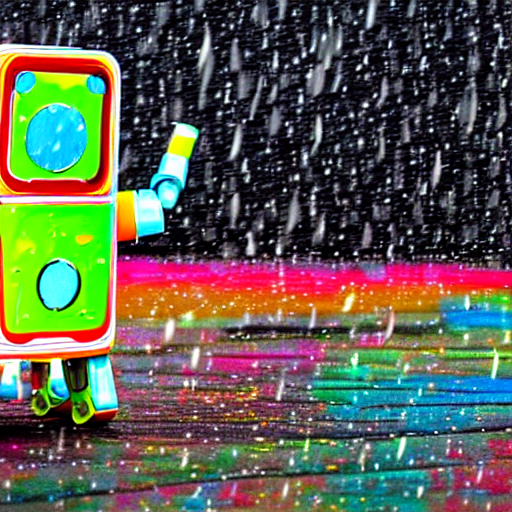

In [36]:
pipe.load_lora_weights("./out/pytorch_lora_weights.safetensors")
generate(pipe, prompt_training, seed)


  0%|          | 0/35 [00:00<?, ?it/s]

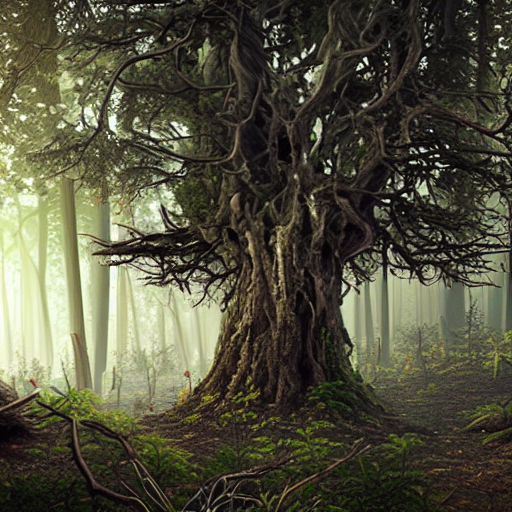

In [37]:
generate(pipe, prompt_new, seed)


# Evaluating the Stable Diffusion Model Using CLIP Score

In [39]:
prompts = [
    "a photo of an astronaut riding a horse on mars",
    "A high tech solarpunk utopia in the Amazon rainforest",
    "A pikachu fine dining with a view to the Eiffel Tower",
    "A mecha robot in a favela in expressionist style",
    "an insect robot preparing a delicious meal",
    "A small cabin on top of a snowy mountain in the style of Disney, artstation",
]

images = pipe(prompts, num_images_per_prompt=1, output_type="np").images

print(images.shape)


  0%|          | 0/50 [00:00<?, ?it/s]

(6, 512, 512, 3)


In [40]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial

clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

def calculate_clip_score(images, prompts):
    images_int = (images * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)

sd_clip_score = calculate_clip_score(images, prompts)
print(f"CLIP score: {sd_clip_score}")
 

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIP score: 34.661
